# Steam Game Data Exploration
## Research Question

Can we use pre-release metadata (price, genres, categories, developers, publishers, and release timing) to understand and eventually predict the popularity of Steam games? 

## Dataset Overview

This dataset is imported from Kaggle for Steam Game from 2021 to 2025. We will import the necessary packages for reading, minimal cleaning, and further exploration.

In [10]:
import pandas as pd

In [3]:
df = pd.read_csv("../data/a_steam_data_2021_2025.csv")
df

,appid,name,release_year,release_date,genres,categories,price,recommendations,developer,publisher
0,3057270,Seafarer's Gambit,2024,"Jul 5, 2024",Action;Adventure;Indie;RPG;Strategy,Single-player;Family Sharing,3.99,0,Bouncy Rocket Studios,Bouncy Rocket Studios
1,3822840,Capitalist Misadventures,2025,"Jul 25, 2025",Casual;Indie;Simulation;Strategy,Single-player;Save Anytime;Family Sharing,7.99,0,Caramelo Studios,Caramelo Studios
2,3216640,The Beast and the Princess,2025,"Jun 17, 2025",Adventure;Indie;Strategy,Single-player;Steam Achievements;Full controll...,12.99,0,Libragames,Libragames
3,2403620,Air Twister,2023,"Nov 10, 2023",Action;Adventure;Indie,Single-player;Steam Achievements;Full controll...,24.99,0,YS Net,ININ
4,1538040,Horde Slayer,2021,"Mar 19, 2021",Action;Adventure;Casual;Indie;RPG;Early Access,Single-player;Steam Achievements;Full controll...,3.99,0,Wagner Rodrigues,Wagner Rodrigues
...,...,...,...,...,...,...,...,...,...,...
65516,3097010,X Simulator Drone,2024,"Jul 31, 2024",Casual;Indie;Simulation,Single-player;Family Sharing,14.99,0,Inonia Games,Inonia Games
65517,3304930,Retro Dungeon Slayer,2025,"Mar 3, 2025",Action;Indie;Early Access,Single-player;Family Sharing,4.99,0,Hard Shark Games,Hard Shark Games
65518,1461580,Molecule Builder,2021,"Feb 4, 2021",Simulation;Education,Single-player;Tracked Controller Support;VR On...,14.99,0,Xennial Digital,Xennial Digital
65519,1379120,MechNest,2024,"Apr 13, 2024",Action;Indie,Single-player;Partial Controller Support;Famil...,15.99,0,PoisonGames,PoisonGames


There are a total of 65521 rows/observations, with 10 columns for the game's ID, name, release year, release date, genres, categories, price, recommendations, developer and publisher. <br/> <br/>
The genres and categories fields are multi-label categorical variables, where each game may belong to multiple genres or support multiple categories. These fields will require multi-label encoding before modeling and are treated separately from single-valued categorical features.

## Data Quality, Structure, and Key Variables

In [9]:
df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65521 entries, 0 to 65520
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   appid            65521 non-null  int64  
 1   name             65521 non-null  object 
 2   release_year     65521 non-null  int64  
 3   release_date     65521 non-null  object 
 4   genres           65455 non-null  object 
 5   categories       65514 non-null  object 
 6   price            65521 non-null  float64
 7   recommendations  65521 non-null  int64  
 8   developer        65468 non-null  object 
 9   publisher        65338 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 5.0+ MB


appid              65521
name               65128
release_year           5
release_date        1828
genres              1723
categories          7993
price                589
recommendations     2536
developer          45679
publisher          41600
dtype: int64

We can see that some columns contain missing data, including `genres`, `categories`, `developer` and `publisher`. The `appid` column's values are all unique, while some duplication is seen in `name`, `developer`, and `publisher`. This means that, while `name`, `developer`, and `publisher` aren't unique, they are high-cardinality. Between these fields, `name` functions primarily as an identifier rather than a generalizable feature for modeling without additional text processing. Although a game’s title may influence user interest at a human level, the name field is almost entirely unique across observations and lacks reusable structure in its raw form. By contrast, fields with more repetition like `developer` and `publisher` may provide more capturable information for prediction.

## Candidate Predictors

Given these observations, we will be using the `release_year`, `genres`, `categories`, `price`, `developer`, and `publisher` fields as predictors in our model, and dropping unique/near-unique fields like `appid` and `name`.

## Popularity Distribution and Target Implications

Since we want to predict the popularity of each game, the recommendations column captures the final popularity outcome rather than information available before release. As such, it will not be used as a feature but will later be used to construct the target variable. <br/> <br/>
We can take a look at the `recommendations` distribution using the histogram below.

Text(0.5, 1.0, 'Distribution of Steam Game Recommendations')

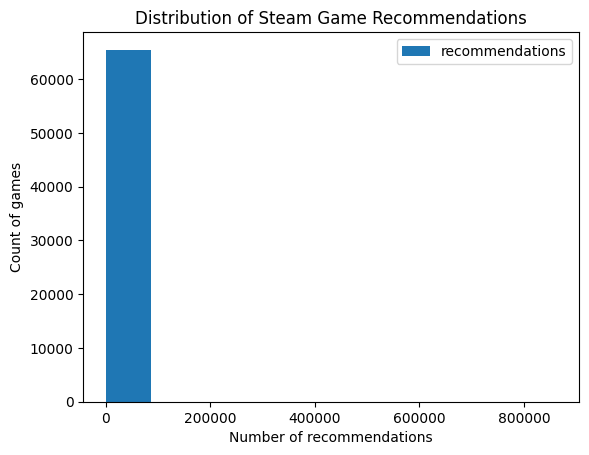

In [5]:
hist = df.plot.hist(y="recommendations")
hist.set_xlabel("Number of recommendations")
hist.set_ylabel("Count of games")
hist.set_title("Distribution of Steam Game Recommendations")

The distribution of recommendations is highly right-skewed, suggesting that only a small number of games receive high recommendations. We can further inspect the values in `recommendations` to see if our data is zero-inflated.

In [6]:
none_zero = len(df[df['recommendations'] != 0])
none_zero

8006

In [7]:
percentage = none_zero / (len(df)) * 100
percentage

12.218983226751728

There are 8,006 observations in total with at least one recommendation, which makes up roughly 12% of all observations in our dataset. While it is common for lots of Steam game to receive no user engagement, this makes it harder for us to use regular quantile-based tiers. Therefore, we will be seperating it into two major groups: zero and none-zero recommendations game. This will give us our first two tiers: 
- Tier 0: No popularity (zero engagement)
- Tier 1+: Some engagement 

After that, we can split the groups with recommendations into further tiers from low to high engagement:
- Tier 1 (bottom 50% of non-zero recommendations): Low popularity
- Tier 2 (50-80% of non-zero recommendations): Moderate popularity
- Tier 3 (top 20% of non-zero recommendations): High popularity